<a href="https://colab.research.google.com/github/hmh100298/MLP_from_Scratch/blob/main/MLP_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(50000, 28, 28) (50000,)
Train dimension:
(50000, 784)
Test dimension:
(10000, 784)
Train labels dimension:
(50000, 10)
Test labels dimension:
(10000, 10)


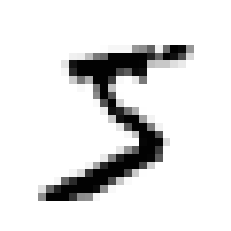

In [83]:

import tensorflow as tf
import keras
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten = False):
  (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

  # normalize x
  X_train = X_train.astype(float) / 255.
  X_test = X_test.astype(float) / 255.

  # we reserve the last 10000 training examples for validation
  X_train, X_val = X_train[:-10000], X_train[-10000:]
  y_train, y_val = y_train[:-10000], y_train[-10000:]

  if flatten:
      X_train = X_train.reshape([X_train.shape[0], -1])
      X_val = X_val.reshape([X_val.shape[0], -1])
      X_test = X_test.reshape([X_test.shape[0], -1])

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
## Printing dimensions
print(X_train.shape, y_train.shape)
## Visualizing the first digit
plt.axis('off')
plt.imshow(X_train[0], cmap="Greys");

## Changing dimension of input images from N*28*28 to  N*784
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

print('Train dimension:');print(X_train.shape)
print('Test dimension:');print(X_test.shape)

##  # chuyen doi label sang one-hot encoded (tien xu ly giup ml nhanh hon)
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
print('Train labels dimension:');print(y_train.shape)
print('Test labels dimension:');print(y_test.shape)

Now we have processed the data, let's start building our multi-layer perceptron using tensorflow


In [84]:
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

s = tf.compat.v1.InteractiveSession() # tf.InteractiveSession() is a way to run tensorflow model directly without instantiating a graph whenever we want to run a model.

# khoi tao cac gia tri 784(Input)-512(Hidden layer 1)-256(Hidden layer 2)-10(Output) neural net model
num_classes = y_train.shape[1]
num_features = X_train.shape[1]
num_output = y_train.shape[1]
num_layers_0 = 512
num_layers_1 = 256
starter_learning_rate = 0.001
regularizer_rate = 0.1
#In tensorflow, we define a placeholder for our input variables and output variables and any variables we want to keep track of.
# Placeholders for the input data
tf.compat.v1.disable_eager_execution()
input_X = tf.compat.v1.placeholder('float32',shape =(None,num_features),name="input_X") #Tensor("input_X_1:0", shape=(None, 784), dtype=float32)
input_y = tf.compat.v1.placeholder('float32',shape = (None,num_classes),name='input_Y')
## for dropout layer
keep_prob = tf.compat.v1.placeholder(tf.float32)

## Weights initialized by random normal function with std_dev = 1/sqrt(number of input features)
weights_0 = tf.Variable(tf.random.normal([num_features,num_layers_0], stddev=(1/tf.sqrt(float(num_features)))))
bias_0 = tf.Variable(tf.random.normal([num_layers_0]))

weights_1 = tf.Variable(tf.random.normal([num_layers_0,num_layers_1], stddev=(1/tf.sqrt(float(num_layers_0)))))
bias_1 = tf.Variable(tf.random.normal([num_layers_1]))

weights_2 = tf.Variable(tf.random.normal([num_layers_1,num_output], stddev=(1/tf.sqrt(float(num_layers_1)))))
bias_2 = tf.Variable(tf.random.normal([num_output]))

hidden_output_0 = tf.nn.relu(tf.matmul(input_X,weights_0)+bias_0)  # use ReLU activation for hidden layers
hidden_output_0_0 = tf.nn.dropout(hidden_output_0, keep_prob)# Dropout is an essential concept in creating redundancies in our network which leads to better generalization.

hidden_output_1 = tf.nn.relu(tf.matmul(hidden_output_0_0,weights_1)+bias_1)
hidden_output_1_1 = tf.nn.dropout(hidden_output_1, keep_prob)

predicted_y = tf.sigmoid(tf.matmul(hidden_output_1_1,weights_2) + bias_2)#  softmax for the final output layer to get class probability score

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [85]:
## Defining the loss function
loss = tf.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_y,labels=input_y))  + regularizer_rate*(tf.reduce_sum(tf.square(bias_0)) + tf.reduce_sum(tf.square(bias_1)))

In [86]:
# xac dinh  learning rate cho mang de toi uu hoa weight and bias 
## Variable learning rate
learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)# use exponential decay on our learning rate by every five epoch to reduce the learning by 15%(0.85)
## Adam optimzer for finding the right weight
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[weights_0,weights_1,weights_2,bias_0,bias_1,bias_2])
## Metrics definition # define accuracy metric to evaluate our model performance as loss function is non-intuitive.
correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(predicted_y,1)) # equal tra ve 1 tensor = shape cua 1 trong 2 (neu ca 2 bang nhau true, true) sai (true,false)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) # chuyen sang tensor sang float lay trung binh

In [88]:
## Training parameters
batch_size = 128
epochs=14
dropout_prob = 0.6

training_accuracy = []
training_loss = []
testing_accuracy = []

s.run(tf.compat.v1.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer, {input_X: X_train[arr[index:index+batch_size]],
                          input_y: y_train[arr[index:index+batch_size]],
                        keep_prob:dropout_prob})
    training_accuracy.append(s.run(accuracy, feed_dict= {input_X:X_train, 
                                                         input_y: y_train,keep_prob:1}))
    training_loss.append(s.run(loss, {input_X: X_train, 
                                      input_y: y_train,keep_prob:1}))
    
    ## Evaluation of model
    testing_accuracy.append(accuracy_score(y_test.argmax(1), 
                            s.run(predicted_y, {input_X: X_test,keep_prob:1}).argmax(1)))
    print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Test acc:{3:.3f}".format(epoch,
                                                                    training_loss[epoch],
                                                                    training_accuracy[epoch],
                                                                   testing_accuracy[epoch]))

Epoch:0, Train loss: nan Train acc: 0.099, Test acc:0.098
Epoch:1, Train loss: nan Train acc: 0.099, Test acc:0.098
Epoch:2, Train loss: nan Train acc: 0.099, Test acc:0.098
Epoch:3, Train loss: nan Train acc: 0.099, Test acc:0.098
Epoch:4, Train loss: nan Train acc: 0.099, Test acc:0.098
Epoch:5, Train loss: nan Train acc: 0.099, Test acc:0.098
Epoch:6, Train loss: nan Train acc: 0.099, Test acc:0.098
Epoch:7, Train loss: nan Train acc: 0.099, Test acc:0.098
Epoch:8, Train loss: nan Train acc: 0.099, Test acc:0.098
Epoch:9, Train loss: nan Train acc: 0.099, Test acc:0.098
Epoch:10, Train loss: nan Train acc: 0.099, Test acc:0.098
Epoch:11, Train loss: nan Train acc: 0.099, Test acc:0.098
Epoch:12, Train loss: nan Train acc: 0.099, Test acc:0.098
Epoch:13, Train loss: nan Train acc: 0.099, Test acc:0.098
